In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("customer_cleaned.csv")
for c in ['sale_date', 'last_purchase_date']:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Preprocess feedback text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

df['feedback_clean'] = df['feedback_text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kashmala.arif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kashmala.arif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kashmala.arif\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    if text == "":
        return 0
    score = sia.polarity_scores(text)
    return score['compound']  # ranges from -1 (negative) to 1 (positive)

df['feedback_sentiment'] = df['feedback_clean'].apply(get_sentiment_score)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kashmala.arif\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
# Aggregate feedback per customer
customer_feedback = df.groupby('customer_id')['feedback_clean'].apply(lambda x: " ".join(x)).reset_index()

# Compute average sentiment per customer
customer_feedback['feedback_sentiment'] = df.groupby('customer_id')['feedback_sentiment'].mean().values

# Vectorize text for LDA
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=500)
X_text = vectorizer.fit_transform(customer_feedback['feedback_clean'])

# LDA model
from sklearn.decomposition import LatentDirichletAllocation
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_features = lda.fit_transform(X_text)

# Add topic distribution as features
for i in range(num_topics):
    customer_feedback[f'topic_{i}'] = lda_features[:, i]

# Now merge into customer_summary
customer_summary = customer_summary.merge(
    customer_feedback[['customer_id', 'feedback_sentiment'] + [f'topic_{i}' for i in range(num_topics)]],
    on='customer_id', how='left'
)

# Fill missing values
customer_summary.fillna(0, inplace=True)


Accuracy: 0.748730964467005

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86       295
           1       0.00      0.00      0.00        99

    accuracy                           0.75       394
   macro avg       0.37      0.50      0.43       394
weighted avg       0.56      0.75      0.64       394



c:\Users\kashmala.arif\OneDrive - Incedo Technology Solutions Ltd\Documents\Capstone Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kashmala.arif\OneDrive - Incedo Technology Solutions Ltd\Documents\Capstone Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kashmala.arif\OneDrive - Incedo Technology Solutions Ltd\Documents\Capstone Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defin

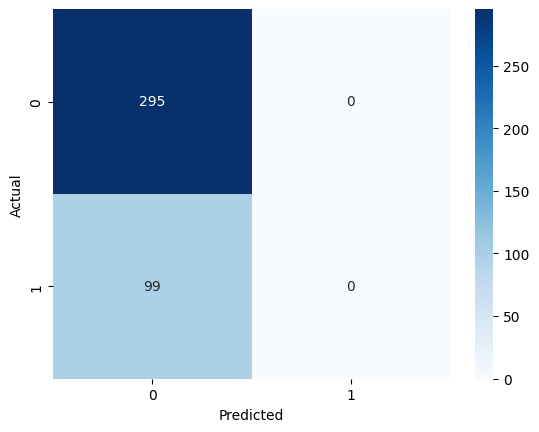

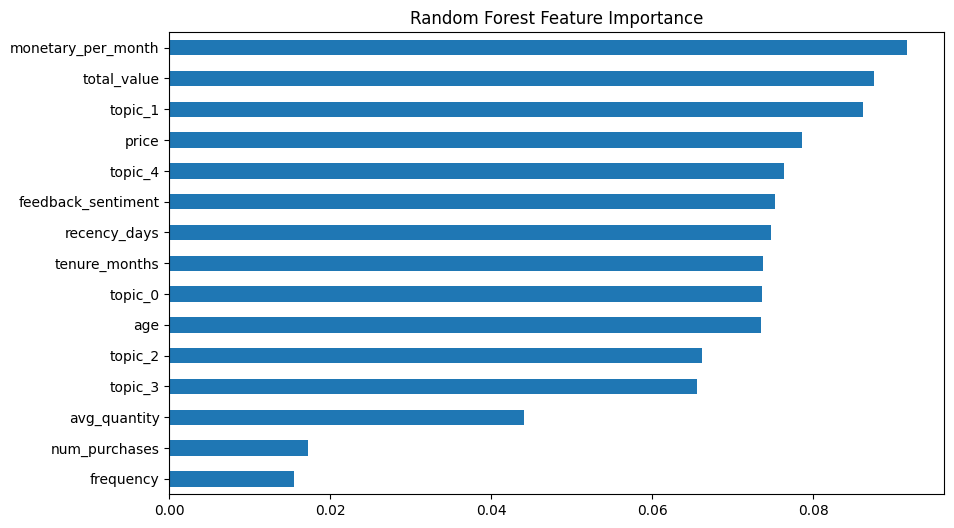

In [17]:
# Numeric feature engineering
# --------------------------
from sklearn.preprocessing import StandardScaler
customer_summary = df.groupby("customer_id").agg({
    "sale_id": "count",
    "total_value": "sum",
    "price": "mean",
    "product_id": pd.Series.nunique,
    "category": pd.Series.nunique,
    "age": "last",
    "tenure_months": "last",
    "churn": "first"
}).reset_index()

customer_summary['num_purchases'] = customer_summary["sale_id"]

avg_quantity = df.groupby("customer_id")["quantity"].mean()
customer_summary = customer_summary.merge(avg_quantity, on="customer_id", how="left")
customer_summary.rename(columns={"quantity": "avg_quantity"}, inplace=True)

# Merge text features
customer_summary = customer_summary.merge(
    customer_feedback[['customer_id', 'feedback_sentiment'] + [f'topic_{i}' for i in range(num_topics)]],
    on='customer_id', how='left'
)

customer_summary.fillna(0, inplace=True)

# --------------------------
# Features for Random Forest
# --------------------------
# --------------------------
# RFM Features
# --------------------------
# Frequency: number of purchases
customer_summary['frequency'] = customer_summary['num_purchases']

# Recency: days since last purchase
df['sale_date'] = pd.to_datetime(df['sale_date'])
last_date = df['sale_date'].max()
recency = df.groupby("customer_id")["sale_date"].max().apply(lambda x: (last_date - x).days)
customer_summary['recency_days'] = recency.values

# Monetary: spend per month (avoid division by zero)
customer_summary['monetary_per_month'] = customer_summary['total_value'] / customer_summary['tenure_months'].replace(0,1)

# --------------------------
# Features for Random Forest (including RFM)
# --------------------------
numeric_features = [
    "num_purchases", "total_value", "price", "avg_quantity", "age", "tenure_months",
    "feedback_sentiment", "frequency", "recency_days", "monetary_per_month"
] + [f'topic_{i}' for i in range(num_topics)]

X = customer_summary[numeric_features]
y = customer_summary["churn"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance
importances = pd.Series(rf.feature_importances_, index=numeric_features).sort_values(ascending=True)
importances.plot(kind='barh', figsize=(10,6), title="Random Forest Feature Importance")
plt.show()


In [13]:
# Function to display top words per topic
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics[f'Topic {topic_idx}'] = top_features
        print(f"Topic {topic_idx}: {', '.join(top_features)}")
    return topics

# Get feature names from CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Display top 10 words per topic
topics = display_topics(lda, feature_names, no_top_words=10)


Topic 0: product, satisfied, great, better, could, quality, recommend, others, highly, use
Topic 1: feature, offered, expensive, recommend, others, highly, nothing, met, special, expectation
Topic 2: happy, price, purchase, worth, late, delivery, product, expectation, special, met
Topic 3: customer, excellent, service, product, buy, terrible, experience, better, could, quality
Topic 4: special, nothing, met, expectation, easy, reliable, use, buy, terrible, experience
